# 課題6 クラスタリング

配点
- Q1 2P
- Q2 6P
- Q3 2P

In [5]:
# matplotlib日本語化用モジュールをインストール
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached japanize-matplotlib-1.1.3.tar.gz (4.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=80effcfdb03a32d6cf1978790c04b4c9dc2dc1632d2859951ad1b06dad8a4f69
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [6]:
# モジュールのインポート
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

## 階層化クラスタリング
以下では、都道府県の気象データについて都道府県間の類似度（距離）に基づき都道府県を階層化クラスタリングすることを考えます。気象データは都道府県ごとの2018年度の年平均気温（℃）と年間降水量（mm）からなり、以下の政府統計ポータルサイトe-Statから取得しました。

[都道府県・市区町村のすがた（社会・人口統計体系）](https://www.e-stat.go.jp/regional-statistics/ssdsview/prefectures)

In [7]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2022A/master/ex6/weather.xlsx

--2023-01-31 12:42:34--  https://raw.githubusercontent.com/UTDataMining/2022A/master/ex6/weather.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11427 (11K) [application/octet-stream]
Saving to: ‘weather.xlsx’

weather.xlsx        100%[===================>]  11.16K  --.-KB/s    in 0s      

2023-01-31 12:42:34 (59.2 MB/s) - ‘weather.xlsx’ saved [11427/11427]



In [8]:
# 気象データファイルの読み込み（年平均気温: Temp、年間降水量: Rain）
weather_df = pd.read_excel('weather.xlsx', header=4, usecols=[0,2,3],  skiprows=[5], skipfooter=4, names=['Pref','Temp','Rain']) 
weather_df

,Pref,Temp,Rain
0,北海道,9.5,1282.0
1,青森県,11.0,1553.0
2,岩手県,11.0,1322.0
3,宮城県,13.6,1082.0
4,秋田県,12.3,2016.5
5,山形県,12.6,1124.0
6,福島県,14.2,828.0
7,茨城県,15.3,1282.5
8,栃木県,15.2,1257.0
9,群馬県,16.1,1046.5


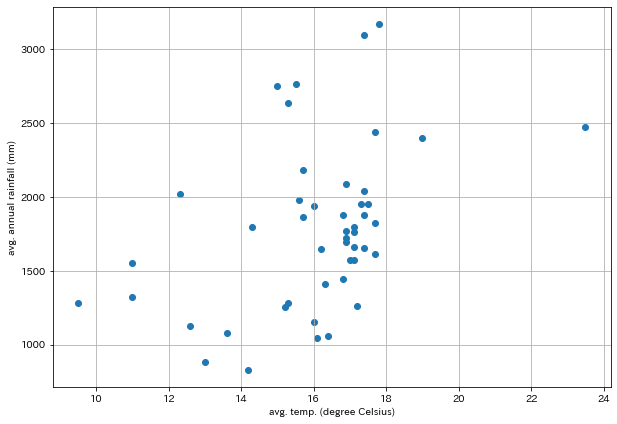

In [9]:
# 散布図
plt.figure(figsize=(10,7))
plt.scatter(weather_df['Temp'], weather_df['Rain'])
plt.xlabel('avg. temp. (degree Celsius)')
plt.ylabel('avg. annual rainfall (mm)')
plt.grid(True);

階層化クラスタリングには`SciPy`の階層化クラスタリングモジュール（`scipy.cluster.hierarchy`）を用います。

`linkage`関数は、特徴量ベクトルを行とする行列を入力とし、`metric`引数で指定した距離尺度と`method`引数で指定した距離計算方法で階層化クラスタリングを行い、特徴量ベクトル間のクラスタリングの過程を行列として返します。

- metric引数に指定できる距離尺度: cosine, euclidean, jaccard, hamming, correlation, mahalanobis, など
  - [距離尺度](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)

- method引数に指定できる距離計算方法: single, complete, average, ward, など
  - [linkage関数と距離計算方法](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

以下では、標準化された都道府県の気象データの2次元配列を`linkage`関数の入力として指定しています。

`dendrogram`関数は、`linkage`関数が出力したクラスタリング過程を表す行列を入力として、クラスタリングの過程をデンドログラムとして可視化します。`labels`引数には各特徴量ベクトル（各都道府県の平均気温と降水量のベクトル）に付与するラベルのリストを指定します。

In [10]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [11]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化

prefs = weather_df['Pref'].values # 都道府県名ラベル

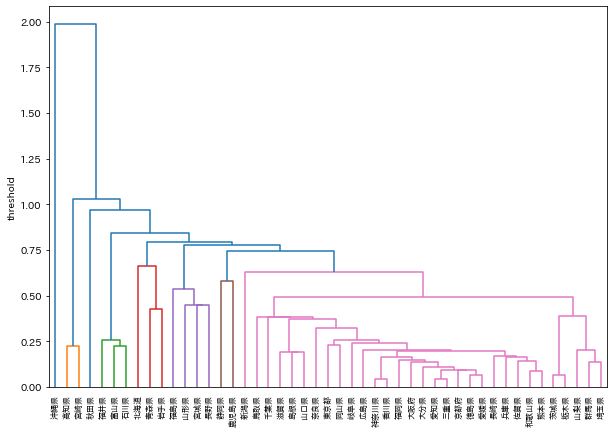

In [12]:
# 距離計算方法single
clusters = linkage(X, metric = 'euclidean', method = 'single')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold');

距離計算方法を`complete`や`average`に変更して階層化クラスタリングを行い得られるクラスタがどのように変化するか、それぞれのデンドログラムを可視化して観察してください。`denderogram`の`color_thereshold`の値を変えることで異なるクラスタ数でクラスタリング結果が色分けされます。

Text(0, 0.5, 'threshold')

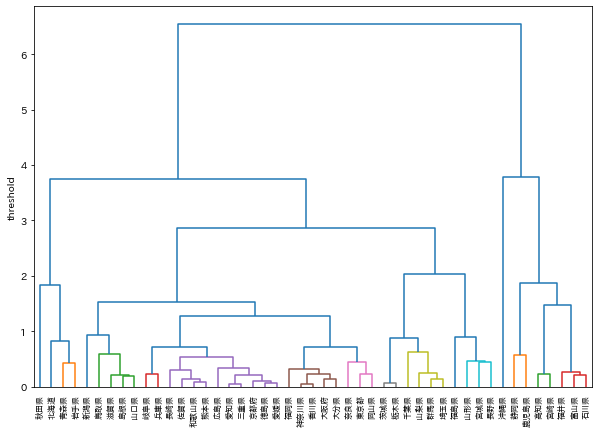

In [13]:
# 距離計算方法complete
clusters = linkage(X, metric = 'euclidean', method = 'complete')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold')

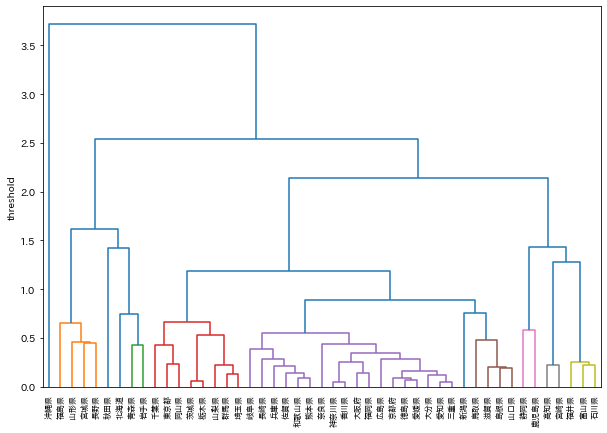

In [ ]:
# 距離計算方法average
clusters = linkage(X, metric = 'euclidean', method = 'average')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold');

### 参考
`linkage`関数には、以下のように特徴量ベクトル間の距離を表す行列を入力することもできます。`pdist`関数は`metric`引数で指定した距離尺度で特徴量ベクトル間の距離を計算し、それらの距離を要素とする行列（正確には行列の上半分をベクトルにしたもの）を返します。距離行列を`linkage`関数の入力とした場合は、`linkage`関数で距離尺度を指定する必要はありません。

[pdist関数](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)

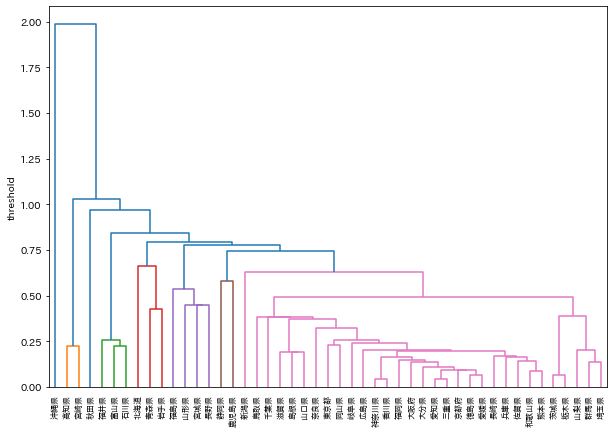

In [14]:
from scipy.spatial.distance import pdist

# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(pdist(X, metric='euclidean'), method='single')

# デンドログラム
plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold');

In [15]:
from scipy.spatial.distance import squareform

# 距離行列
dist_matrix = pd.DataFrame(squareform(pdist(X, metric='euclidean')), columns=prefs, index=prefs)
dist_matrix

,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,群馬県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
北海道,0.000000,0.827093,0.664314,1.841703,1.828107,1.395049,2.230728,2.552896,2.509301,2.937099,...,3.476308,4.813317,3.661426,3.645189,3.742800,3.729513,3.417708,5.035887,4.656808,6.537396
青森県,0.827093,0.000000,0.424643,1.435032,1.026348,1.057303,1.939094,1.956895,1.927065,2.430226,...,2.721999,3.993057,2.951380,2.879265,2.989903,2.952844,2.692546,4.215068,3.847893,5.754106
岩手県,0.664314,0.424643,0.000000,1.226499,1.399050,0.792745,1.675864,1.894056,1.852506,2.301208,...,2.823076,4.304455,2.998481,2.996051,3.088405,3.085482,2.757147,4.524126,4.037855,5.892446
宮城県,1.841703,1.435032,1.226499,0.000000,1.810663,0.446875,0.536435,0.834113,0.774244,1.102319,...,2.024455,4.056716,2.055221,2.221111,2.258804,2.344288,1.874560,4.256174,3.390113,5.049127
秋田県,1.828107,1.026348,1.399050,1.810663,0.000000,1.645970,2.339385,1.887916,1.891724,2.444812,...,2.151100,2.991908,2.487704,2.259388,2.403850,2.292016,2.210420,3.215179,3.030851,4.999569
山形県,1.395049,1.057303,0.792745,0.446875,1.645970,0.000000,0.889968,1.223613,1.170227,1.547114,...,2.334834,4.190267,2.420826,2.525818,2.584715,2.638179,2.214701,4.398876,3.662190,5.397731
福島県,2.230728,1.939094,1.675864,0.536435,2.339385,0.889968,0.000000,0.965649,0.903140,0.927750,...,2.190674,4.394615,2.115877,2.387973,2.388597,2.523429,1.996355,4.583281,3.575282,5.085445
茨城県,2.552896,1.956895,1.894056,0.834113,1.887916,1.223613,0.965649,0.000000,0.064302,0.558751,...,1.233084,3.453291,1.222304,1.431333,1.447705,1.563840,1.056862,3.635681,2.617189,4.217594
栃木県,2.509301,1.927065,1.852506,0.774244,1.891724,1.170227,0.903140,0.064302,0.000000,0.553771,...,1.297289,3.510365,1.284057,1.495552,1.511881,1.627912,1.120898,3.693784,2.681278,4.279548
群馬県,2.937099,2.430226,2.301208,1.102319,2.444812,1.547114,0.927750,0.558751,0.553771,0.000000,...,1.447266,3.804399,1.263257,1.630399,1.588403,1.772377,1.215773,3.970144,2.791525,4.177532


## k-means法

### Q1 平方ユークリッド距離

$n$-次元ベクトル空間における、任意の2つのベクトル、$ \vec{x}=(x_1,x_2,...,x_n)$、$\vec{y}=(y_1,y_2,...,y_n)$、の間の平方ユークリッド距離$ \| \vec{x}- \vec{y}\|^2$は以下のように定義されます。

$\Sigma^{n}_{i=1}(x_{i}-y_{i})^2=\vec{x}\cdot\vec{x}+\vec{y}\cdot\vec{y}-2\vec{x}\cdot\vec{y}$

入力ベクトル $\vec{x}$, $\vec{y}$ をそれぞれ`NumPy` の配列として引数`x`、`y`で受け取り、それらのベクトル間の平方ユークリッド距離を計算して返す関数 `squared_euclid` を完成させてください。

In [16]:
def squared_euclid(x, y):
  return sum(x[i]*x[i]+y[i]*y[i]-2*x[i]*y[i] for i in range(len(x)))

`squared_euclid()`関数が完成したら、以下のセルを実行して動作を確認してください。

In [17]:
print(squared_euclid(np.array([1,0,1]), np.array([1,1,1])))
print(squared_euclid(np.array([1,1,1]), np.array([1,1,1])))
print(squared_euclid(np.array([-1,-1,-1]), np.array([1,1,1])))

1
0
12


結果は、`1`、`0`、`12`、となります。

### Q2 k-means法の実装
以下では、k-means法によるクラスタリングを行う`kmeans`関数を実装します。`kmeans`関数では第1引数に入力`X`（データ数($m$)$\times$特徴量数($n$)の行列）、第2引数にクラスタ数を受け取り、以下の処理を行います。（引数には第3引数に中心への割り当てと中心点の更新の繰り返し数（既定値10）、第4引数に中心をランダムに選ぶ際のシード（既定値2）、を指定できますが省略可能です。）

- 初期化
  - まず、クラスタの数($K$)だけ中心を入力データからランダムに選び、それらを初期の中心$\mu^{(k)} (k=0,...,K-1)$とします。

- 1. 中心への割り当て
  - 各データ$x^{(i)} (i=0,...,m-1)$と各中心$\mu^{(k)}$の平方ユークリッド距離を計算し、その結果を距離行列`d[i,k]`に代入します。距離行列`d`はデータを行、中心を列として、各データと各中心の距離を要素とする行列です。

  - 距離行列`d[i,k]`の各行について、その行に対応するデータに最も近い中心をそのデータが属するクラスタの中心として選びます。これにより、各データ$x^{(i)}$がどのクラスタ中心$\mu^{(k)}$に属するかを表す以下の配列`clusters`を更新します。

    - データ$x^{(i)}$の最近接の中心が$\mu^{(k)}$であれば`clusters[i]=k`

    - この時、以下のように距離行列`d`の各行ごとにその行の最小値を持つ列のインデックスを`np.argmin`で取得することで配列`clusters`を作成できます。
```Python
clusters = np.argmin(d,axis=1)
```

- 2. 中心の更新

  - そして、各中心$\mu^{(k)}$に属するデータ$x^{(k,i)}$を用いて各中心を更新します

  - $\mu^{(k)}= \Sigma_{i} x^{(k,i)}/(\mu^{(k)}に属するデータ数)$

  - この時、`clusters`配列とインデックス参照を用いて、中心$\mu^{(k)}$に属するデータの特徴ベクトル集合を入力`X`から以下のように取得できます。
```Python
X[clusters==k,:]
```
  - これらの特徴ベクトルの平均のベクトル（ヒント:`np.mean`)を新たな中心$\mu^{(k)}$のベクトルとします。

k-means法では、上記のデータの中心への割り当てと中心の更新を繰り返すことで、クラスタリングを行います。繰り返し処理が終わったら、`kmeans`関数は、各データの所属するクラスタを表す配列`clusters`、各クラスタ中心のベクトルを行とする行列`centers`、最終的なコスト関数の値`cost`を返します。上記に従って、`kmeans`関数を完成させてください。

In [18]:
def kmeans(X, n_clusters, max_iter=10, rand_seed=2): 
    ### 引数：
    # X: 入力データ（データ数x特徴量数の行列）
    # n_clusters: クラスタ数
    # max_iter: 中心への割り当てと中心の更新の繰り返し数
    # rand_seed: 中心をランダムに選ぶ際のシード
    
    # クラスタ数のだけ中心を入力データからランダムに選ぶ
        # 補: k-means++の場合は、この中心を選び方を変更
        # 補: また、クラスタ数が比較的小さい時は異なる初期中心を試し
        # 最終的にコストが小さくなる初期中心を採用するのがよい
    np.random.seed(rand_seed)    
    centers=X[np.random.choice(X.shape[0], n_clusters, replace=False), :]
    
    # 各特徴量ベクトルと中心点ベクトルの距離を表す2次元配列（入力データ数xクラスタ数）の初期化
    d=[[0]*n_clusters for i in range(len(X))]

    # 各データの所属するクラスタ（中心）を表す1次元配列の初期化
    clusters = [0]*len(X)
    
    
    for _ in range(max_iter,-1,-1):
    # 以下をmax_iter回だけ繰り返し
        # 1. 中心への割り当て
        ### 入力データiの特徴量ベクトルと中心kのベクトルの平方ユークリッド距離を計算して、d[i,k]を更新するコード
        
        for i in range(len(X)):
         
          for k in range(n_clusters):
            d[i][k]=squared_euclid(X[i],centers[k])
       
        clusters = np.argmin(d,axis=1)
        ###  各データiがどの中心kに属するかを表す配列clustersを更新（clusters[i]=k)するコード
           
        # 2. 中心の更新
        ### 中心kに属するデータiだけを用いて中心kのベクトルcenters[k,:]を更新するコード
        centers=[0]*n_clusters
        for k in range(n_clusters):
          X_input=X[clusters==k,:]
          centers[k]=[sum(X_input[i][0] for i in range(len(X_input)))/len(X_input),sum(X_input[i][1] for i in range(len(X_input)))/len(X_input)]        
    # コストの計算
    cost =  sum(squared_euclid(X[i],centers[clusters[i]]) for i in range(len(clusters))) # コスト（各データ点とその中心の平方ユークリッド距離の総和）の計算
   
    centers=np.array(centers)
    return clusters, centers, cost 

`kmeans`関数が完成したら以下のセルを実行して動作を確認してください。

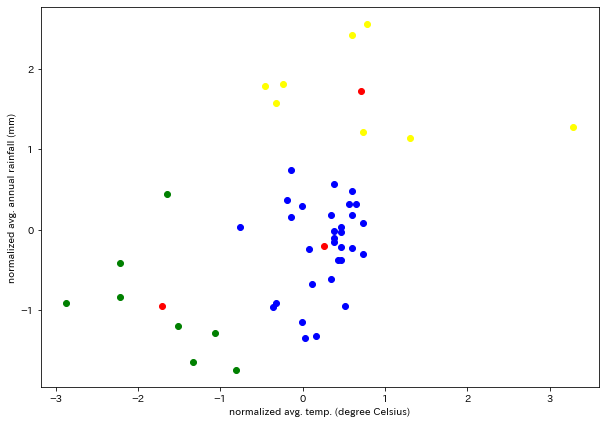

In [ ]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化
clusters, centers, cost=kmeans(X, 3)

# 可視化
plt.figure(figsize=(10,7))
plt.xlabel('normalized avg. temp. (degree Celsius)')
plt.ylabel('normalized avg. annual rainfall (mm)')
plt.scatter(X[clusters==0,0],X[clusters==0,1],c='blue')
plt.scatter(X[clusters==1,0],X[clusters==1,1],c='green')
plt.scatter(X[clusters==2,0],X[clusters==2,1],c='yellow')
plt.scatter(centers[:,0], centers[:,1], c='red'); # クラスタの中心点

最終的なコスト関数の値は$\simeq32$、クラスタの中心点は`(0.2..., -0.1...)`、`(-1.7..., -0.9...)`、`(0.7..., 1.7...)`となります。

In [ ]:
# コスト関数の値
print(cost)

# クラスタの中心点
print(centers)

32.39278477410994
[[ 0.25666107 -0.19969693]
 [-1.70770545 -0.94854049]
 [ 0.71314379  1.72236611]]


scikit-learnのKMeansモデルを用いると以下のようにk-means法を実行できます。


32.39278477410994
[[-1.70770545 -0.94854049]
 [ 0.25666107 -0.19969693]
 [ 0.71314379  1.72236611]]


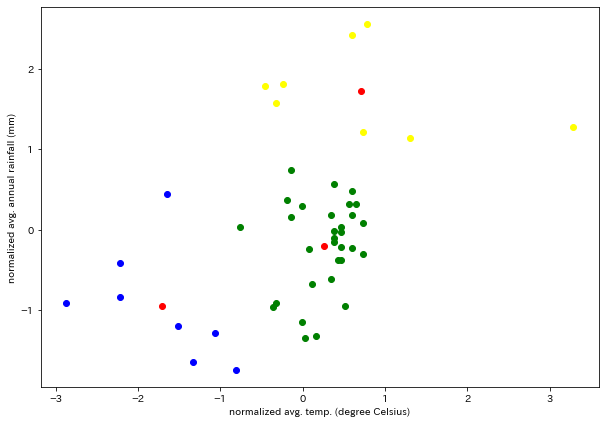

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3) 
model.fit(X) 
clusters=model.predict(X) 

plt.figure(figsize=(10,7))
plt.xlabel('normalized avg. temp. (degree Celsius)')
plt.ylabel('normalized avg. annual rainfall (mm)')
plt.scatter(X[clusters==0,0],X[clusters==0,1],c='blue')
plt.scatter(X[clusters==1,0],X[clusters==1,1],c='green')
plt.scatter(X[clusters==2,0],X[clusters==2,1],c='yellow')

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='red'); # クラスタの中心点
print(model.inertia_) # コスト関数の値
print(model.cluster_centers_) # クラスタの中心点

### Q3 エルボー法
クラスタリングにおいて、クラスタ数を変化させた時のクラスタリングのコストの変化に基づいて、最適なクラスタ数を決定する方法をエルボー法と呼びます。エルボー法では、クラスタ数を増やしていった時にコストが最も大きく減少しその後の減少が緩やかになる（グラフの”肘”ができる）時のクラスタ数を採用します。以下の`elbow`関数は、Q2で作成した`kmeans`関数を用いて、クラスタ数を1から`K`まで1つずつ増やしていった時のクラスタリングのコストの値を要素とするリストを返します。`elbow`関数を完成させてください。



In [ ]:
def elbow(X, K):
    ### 引数：
    # X: 入力データ
    # K: 最大のクラスタ数    
    
    # 各クラスタ数でのコストをいれるリスト
    costs=[]
    
    #1からKまでのクラスタ数kそれぞれで入力データをkmeans法でクラスタリングした時の最終的なコストをcostsに追加するコード 
    for i in range(1,K+1):
      cost=kmeans(X,i)[2]
      costs.append(cost)   
    print(costs)

    return costs

[94.00000000000001, 53.69337143477687, 32.39278477410994, 25.703998055576253, 21.97915865778336, 15.45565810576456, 12.136127640098174, 10.336688477489393, 7.0924498257152555, 8.087652333095, 5.103120644234671, 6.76362774904274, 4.803412957025645, 4.784181552970656, 4.660017363894891]


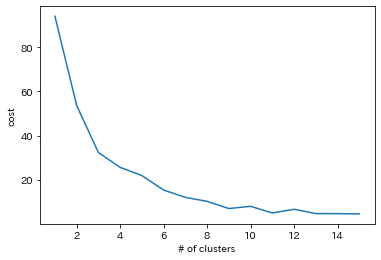

In [ ]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化
K = 15
costs = elbow(X, 15)

plt.xlabel("# of clusters")
plt.ylabel("cost")
plt.plot(range(1,K+1),costs);


### 参考
地図上でのクラスタの可視化

In [ ]:
!pip install japanmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 4.7 MB/s 


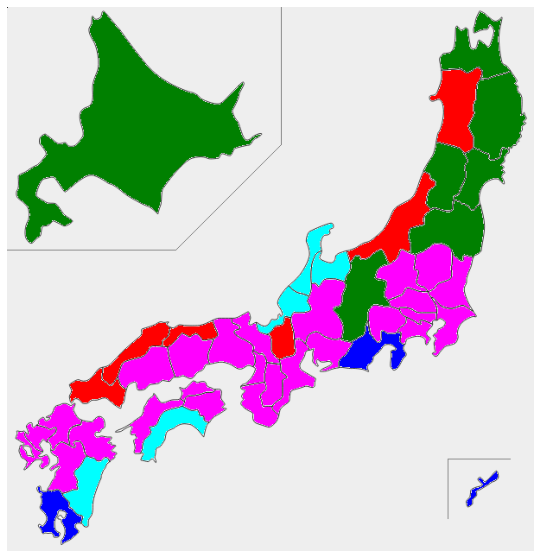

In [ ]:
import japanmap as jm
colors = {0:"red", 1:"green", 2:"blue", 3:"cyan", 4:"magenta", 5:"yellow", 6:"black", 7:"white"}
k=5
plt.figure(figsize=(10, 10))
plt.imshow(jm.picture({p:c for p, c in zip(weather_df['Pref'].values, [colors[c] for c in kmeans(X, k)[0]])}))
plt.axis('off');

## コードのテスト
以下の実行ボタンを押してから、設問ごとにCheck関数でコードのテストをしてください。

In [ ]:
## コードのテストの前にこのセルを実行してください
!pip install prog_edu_assistant_tools
import re
import sys
import jinja2
from IPython.core import display
from google.colab import _message as google_message
from prog_edu_assistant_tools.magics import report, autotest, CaptureOutput
from prog_edu_assistant_tools.check import Check

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


## Q1

In [ ]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q1')

## Q2

In [ ]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q2')

## Q3

In [ ]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q3')